# MSIN0097 - Individual Assignment - Predicting World Record Speedruns Using Historical Data

[Link to Github Repo with this Notebook](https://github.com/cyalen/my_assignment)

## The Business Problem - To Run Or Not To Run

Even before the COVID-19 pandemic forced us all indoors for indeterminate amounts of time, creating video content around highly skilled video gaming had become a billion-dollar industry. In 2014, when Amazon bought popular streaming platform Twitch for $1.1 billion USD,  which at that point was still almost exclusively still a video gaming focused platform,  it effectively made a statement that this particular subset of the online media sphere was worth significant financial investment (Raghunath, 2020). While there are many communities of viewers and streamers who drove Twitch and other platforms like it to their current level of significance, one particular subset that garners attention is the “speedrunning” community: a group a gamers who sole objective is to finish games as fast a humanly possible by using all manner of glitches, frame-perfect inputs, and AI assisted tools. Much like their other streamer peers, these “runners” (in the common parlance) are primarily supported in their efforts through keeping a regular streaming schedule and garnering views, subs, and donations from their followers in whichever video streaming ecosystem they have joined. They are also patronized by visitors to popular community websites such as Speedrun.com, which hosts and moderates the official leaderboards for the wide majority of the speedrunning community. Yet in the pursuit of earning this patronage, like with many forms of media today, these content creators face huge problem: discoverability.


Suppose you wanted to start speedrunning your favorite video game, and make some money while you did it. How do you get noticed? Naturally your first thought is “make as much content as you can, and stream as much as possible”. While certainly part of the equation, it would be a highly inefficient means of drawing new traffic to your channel. Ideally, you would want to find a way to set yourself apart from the crowd, and for a speedrunner, there is nothing that does so better than achieving a world record for a given game. This however, leads us to our next problem, is that you aren’t the only one gunning for these records. There are many established runners throughout the community, and therefore the more popular and view-friendly a title is, the more competitive of a landscape it is likely to be. In short: there is substantial cost in streaming all the time, there is performance target the you need to hit in order to make yourself profitable, but you also need to make sure that you have properly surveyed your market, and know who your competitors are. How does one streamer do this alone?

## Project Scope

In this assignment, I hope to lay the groundwork for a potential solution to the problems listed above. By using speedrun data from one of the most popular speedrunning communities and games, Speedrun.com and Super Mario 64, I hope to use supervised learning techniques to train a binary classifier to accurately predict whether or not a given speedrun is “world record” based solely on features of the run, the runner, and some of the community engagement around the run, as measured through views on Youtube or Twitch. By successfully training a model on this foundational task, I hope to explore which features of a run are most important to a successful world record prediction, as well as which model varieties are suited to it. If I am successful, then perhaps there is a way for streamers to better assess their competitive landscape by being able to use models such as this to predict the likelihood or frequency of such world records, and therefore be able to invest their time more efficiently into speedrunning games where they are most likely to achieve them.

## Module Imports/Function Definitions

In [11]:
# !pip install requests
# !pip install selenium
# !pip install lxml
import requests
import json
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV, permutation_test_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform
import datetime
import time
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from lxml import html
import selenium 
from selenium import webdriver

## Requesting and Scraping the Data

To begin, I have defined a few functions to assist in my data collection. As mentioned previously, I am using Speedrun.com's run data for Super Mario 64 as my starting point. Speedrun.com has a publicly available API which I used along with the `requests` module to query the necessary data.

Documentation for the API can be found on this [Github repo](https://github.com/speedruncomorg/api). While I don't use any specific functions within, I did reference its contents frequently so I could pull the data I required.

Also I used the 'url' field from Speedrun.com, along with `selenium` and `BeautifulSoup` to parse data from Twitch and Youtube respectively. The urls link to a recorded video of the speedrun, as part of the requirements of submitting a run to the website. 'selenium' was required for Twitch because their view counts are requested by scripts, not embedded in the HTML, so I opted for a Chromedriver implementation. It is however, much, much slower, which is why I retained BS for YouTube to help speed along the gathering process.

Additionally, while there are other VOD services that speedrunners submit their runs with, I restricted my scraping activities to Twitch and Youtube for scoping purposes. A large majority of runs are submitted using these platforms, and considering that it only compromises one dimension of my overall set, it did not seem prudent to pursue at this time. Future implementations could expand in this area.

In [12]:
def scrape_runs(game_id):
    """
    Connects to Speedrun API and requests most up-to-date verified run data for a specific game. Returns a DataFrame.
    """
    #initialize a few variables
    runs_run_id = []
    runs_runner_id = []
    runs_game_id = []
    runs_category = []
    runs_level = []
    runs_timestamp = []
    runs_runtime = []
    runs_system = []
    runs_url = []
    #This dictionary allows us to inject parameters that we can increment later
    #Game ID for SM64 = o1y9wo6q
    payload = {'max': 200, 'offset': 0, 'game': game_id}
    print("Scraping Speedrun.com")
    
    
    #This loop works similar to scrape_gamelist(), iterating through the requested json/dict to individual values
    while True:
        try:
        #     #Lots of holes on the API-side, so this mess of error-handling keeps things going
            for j in requests.get('https://www.speedrun.com/api/v1/runs', params=payload).json()['data']:
                #We don't want to pull any rejected runs
                if j['status']['status'] == 'verified':
                    #There are several differences with how the API handles runner/user records.
                    #"Users" have ids, "guests" have names, some older runs have empty lists. While messy, this handles all three, otherwise you will get an error one way or another
                    try:
                        runs_runner_id.append(j['players'][0]['id'])
                    except IndexError:
                        #Append a null value if we hit an empty list (no ID)
                        runs_runner_id.append(np.nan)
                    except KeyError:
                        #If we get a record with a "guest", we'll pull their name instead
                        try:
                            runs_runner_id.append(j['players'][0]['name'])
                        except IndexError:
                            #Append a null value if we hit an empty list (no ID)
                            runs_runner_id.append(np.nan)
                    #Some games haves level-specifc runs, but this will cause a key error if we call for it and it's not there, therefore fill it a NaN otherwise
                    try:
                        runs_level.append(j['level'])
                    except KeyError:
                        runs_level.append(np.nan)
                    #Most recent runs also have accompanying links to the recorded run itself, but some runs don't, or don't even include the 'links' key.
                    try:
                        runs_url.append(j['videos']['links'][0]['uri'])
                    except KeyError:
                        runs_url.append(np.nan)
                    except TypeError:
                        runs_url.append(np.nan)

                    #Data is far more consistent for the dimensions below - thus no further handling required
                    runs_run_id.append(j['id'])
                    runs_game_id.append(j['game'])
                    runs_category.append(j['category'])
                    runs_timestamp.append(j['date'])
                    runs_runtime.append(j['times']['primary_t'])
                    runs_system.append(j['system']['platform'])
            #If we haven't hit the last page of records yet, we want to increment our offset and keep going, else we want break the whole loop entirely
            if requests.get('https://www.speedrun.com/api/v1/runs', params=payload).json()['pagination']['size'] == 200:
                payload["offset"] += 200
                continue
            else:
                break
        #The API will throw a 420 error if we make too many requests in a given minute. If we encounter one, this block will pause us momentarily
        except KeyError:
            print('Whoops! Need to sleep')
            time.sleep(60)
            continue
    
    #Finally, convert all our lists into Series, and concat into a single DataFrame.
    s_id = pd.Series(runs_run_id, name='run_id')
    s_runner = pd.Series(runs_runner_id, name='runner_id')
    s_game_id = pd.Series(runs_game_id, name='game_id')
    s_category = pd.Series(runs_category, name='category_id')
    s_timestamp = pd.Series(runs_timestamp, name='timestamp')
    s_runtime = pd.Series(runs_runtime, name='run_time')
    s_system = pd.Series(runs_system, name='system_id')
    s_level = pd.Series(runs_level, name='level_id')
    s_url = pd.Series(runs_url, name='url')
    runs_df = pd.concat([s_id, s_runner, s_game_id, s_category, s_level, s_runtime, s_timestamp, s_system, s_url], axis=1)
    print("Complete!")
    return runs_df

#We will load our completed runs_df from Speedrun.com into this. Since Speedrun does not make the former status of a run available through their API, I had to manually calculate based on the timestamp and run time, if a run was world record at some point in the past.
def create_game_hist(df):
    wr_hist = []
    wr_dict = {}
    #Want run data to be sorted so we start with the oldest runs first
    sorted_runs = df.sort_values(['timestamp'])

    for row in sorted_runs.iterrows():
        #Create a new world record entry if we do not already have that category present
        if row[1]['category_id'] not in wr_dict:
            wr_dict[row[1]['category_id']] = {row[1]['system_id']: [row[1]['run_time'], row[1]['timestamp']]}
            #Append the row_id to this list, will use this to set which runs are WRs
            wr_hist.append(row[0])
        #Create a new world record if we do not have the system_id present either
        elif row[1]['system_id'] not in wr_dict.get(row[1]['category_id']):
            wr_dict[row[1]['category_id']][row[1]['system_id']] = [row[1]['run_time'], row[1]['timestamp']]
            wr_hist.append(row[0])
        #If a world record already exists, see if our current run was faster AND more recent, if so, add its info to the dictionary
        elif row[1]['run_time'] < wr_dict.get(row[1]['category_id']).get(row[1]['system_id'])[0] and row[1]['timestamp'] >= wr_dict.get(row[1]['category_id']).get(row[1]['system_id'])[1]:
            wr_dict[row[1]['category_id']][row[1]['system_id']][0] = row[1]['run_time']
            wr_dict[row[1]['category_id']][row[1]['system_id']][1] = row[1]['timestamp']
            wr_hist.append(row[0])
        else:
            continue
    #Insert a new column with our WR data into the dataframe
    df.insert(loc=len(df.columns), column='former_wr', value=False)
    #Set our list of WRs to this new column
    df.loc[wr_hist, 'former_wr'] = True
    return df

#While this implmentation works, it is time-consuming as the inital df has approx. 18,000 rows, almost all of which have URLs!
#I scraped in short batches to keep from losing progress if I encountered an error, but in theory it should execute for the whole set without the need to do so
def scrape_views(start, stop):
    #Initialize a list to append later
    run_views = []
    #Videos autoplay with audio on unless you add this arg
    webdriver.ChromeOptions().add_argument("--mute-audio")
    #Fetch Chromedriver.exe from local path - this has been deliberately left null for anonymity (student name in filepath). If your chromedriver.exe exists in another directory, add it here
    driver = webdriver.Chrome(executable_path = './chromedriver.exe')
    #Set window to auto-shrink when re-starting instance
    driver.set_window_size(0, 0)
    #Using a list comprehension here because directly iterating over the series slices leads to some funnny behavior, but works fine for list.
    for url in [i for i in runs_df['url'][start: stop]]:
        #First of many try-except blocks
        try:
            #Twitch Block
            if "twitch" in url:
                try:
                    #Open url with driver instance
                    driver.get(url)
                    #Add view count element a specific xpath to var
                    viewcount = driver.find_element_by_xpath("""//*[@id="root"]/div/div[2]/div/main/div[2]/div[3]/div/div/div[1]/div[1]/div[2]/div/div[1]/div/div[1]/div[2]/div/div[1]/div/div[1]/div[2]""")
                    #Convert selenium html element to text and append to our views list
                    run_views.append(viewcount.text)
                #If first xpath didn't work try this one
                except selenium.webdriver.remote.errorhandler.NoSuchElementException:
                    try:
                        viewcount = driver.find_element_by_xpath("""//*[@id="root"]/div/div[2]/div[2]/main/div[2]/div[3]/div/div/div[1]/div[1]/div[2]/div/div[1]/div/div[1]/div[2]/div/div[1]/div/div[1]/div[2]""")
                        run_views.append(viewcount.text)
                    #If neither work, its okay, the video likely got taken down
                    except selenium.webdriver.remote.errorhandler.NoSuchElementException:
                        run_views.append(np.nan)
                #If the driver instance hangs, quit the instance and start a fresh one
                except selenium.webdriver.remote.errorhandler.WebDriverException:
                    driver.quit()
                    #Fetch Chromedriver.exe from local path - this has been deliberately left null for anonymity (student name in filepath). If your chromedriver.exe exists in another directory, add it here
                    driver = webdriver.Chrome(executable_path = None)
                    driver.set_window_size(0, 0)
                    driver.get(url)
                    #Xpath try block 2.0
                    try:
                        viewcount = driver.find_element_by_xpath("""//*[@id="root"]/div/div[2]/div/main/div[2]/div[3]/div/div/div[1]/div[1]/div[2]/div/div[1]/div/div[1]/div[2]/div/div[1]/div/div[1]/div[2]""")
                        run_views.append(viewcount.text)
                    except selenium.webdriver.remote.errorhandler.NoSuchElementException:
                        try:
                            viewcount = driver.find_element_by_xpath("""//*[@id="root"]/div/div[2]/div[2]/main/div[2]/div[3]/div/div/div[1]/div[1]/div[2]/div/div[1]/div/div[1]/div[2]/div/div[1]/div/div[1]/div[2]""")
                            run_views.append(viewcount.text)
                        except selenium.webdriver.remote.errorhandler.NoSuchElementException:
                            run_views.append(np.nan)
                        except OSError:
                            run_views.append(np.nan)
                #Just in case any acts of god happen (wifi goes out, page hangs, etc.)
                except selenium.webdriver.remote.errorhandler.AttributeError:
                    run_views.append(np.nan)
                except selenium.webdriver.remote.errorhandler.TimeoutException:
                    run_views.append(np.nan)
                except OSError:
                    run_views.append(np.nan)
                continue
            #Youtube block
            elif 'youtu' in url:  
                try:
                    #Build our soup
                    soup = BeautifulSoup(requests.get(url).text, 'lxml')
                    #Pull view metadata from soup and append to list (so much easier)
                    run_views.append(soup.select_one('meta[itemprop="interactionCount"][content]')['content'])
                #In case video was taken down
                except TypeError:
                    run_views.append(np.nan)
                except OSError:
                    run_views.append(np.nan)
                except ConnectionError:
                    run_views.append(np.nan)
                continue
            #If a video is note Twitch OR Youtube
            else:
                run_views.append(np.nan)
                continue
        except TypeError:
            run_views.append(np.nan)
    #Quit chromedriver instance when done
    driver.quit()
    return run_views

#Slightly modified version of a similiar function from Chapter 2 of Hands On Machine Learning
#Plot precision/recall tradeoff
def plot_precision_recall(prec, rec, thresh):
    #Set line colors
    plt.plot(thresh, prec[:-1], "g-", label="Precision")
    plt.plot(thresh, rec[:-1], "b-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    plt.ylim([0, 1])

#To make our output a bit more easily reproducible
def get_eval_scores(x_set, y_set, class_pred, estimator):
    #Get our desired metrics
    prec = precision_score(y_set, class_pred)
    rec = recall_score(y_set, class_pred)
    f1 = f1_score(y_set, class_pred)
    #Take mean accuracy of all three runs
    acc = estimator.score(x_set, y_set)
    auc = roc_auc_score(y_set, class_pred)

    #Printing results
    print("Estimator: " + str(estimator))
    print("Precision: " + str(round(prec,2)))
    print("Recall: " + str(round(rec,2)))
    print("F1: " + str(round(f1,2)))
    print("Accuracy: " + str(round(acc, 2)))
    print("AUC: " + str(round(auc,2)))
    print("-----")
    #Return metrics to add/unpack later
    return f1, acc, auc

Once I have defined these functions I used them below to request the run data from Speedrun.com and scrape it from Twitch and Youtube. However, for convenience I have included a csv version of my files in my submission in order to save time runnning these cells, as they take a significant amount of time to scrape.

In [13]:
# runs_df = scrape_runs()
# views = scrape_views()
# views_s = pd.Series(views, name="run_views")
# runs_df = pd.concat([runs_df, views_s], axis=1)
#runs_df.to_csv("./runs_df.csv")

In [14]:
#Load csv from this block!
runs_df = pd.read_csv("./runs_df_2.csv")
runs_df.drop("Unnamed: 0", inplace=True, axis=1)

## Cleaning and Exploring the Data

Now that we have the data necessary, lets take a peek at what we have so far. Our intial features are:

 - *run_id*: a unique id given to each instance of data

 - *runner_id*: a unique id given to each speedrunner, usually an alphannumeric combo, but some older ids are usernames

 - *game_id*: unique id for a given title - since we are only looking at Super Mario 64 speedruns we only have one id listed. We'll be droppping this column shortly.

 - *category_id*: unique id for a category of speedrun, these define the variety of objectives a runner must achieve in order to have the run considered, more on this later

 - *level_id*: unique id for a level-based speedrun. For games that have individual levels (like Super Mario 64) sometimes runners will attempt single-level runs. Were are not considering these runs for our analysis, and have only included this tag as so to make it easier to remove these runs from our training set later.

 - *run_time*: the duration of the speedrun in ISO 8601 format.

 - *timestamp*: the date the run was submitted in YYYY-MM-DD format. Some older runs do not have known dates, which we will be dropping from our training set.

 - *system_id*: unique id for the hardware that the run was completed on (console, PC, emulator, etc). More on this later as well. 

 - *url*: the url for the recording of the run. Now that we've scraped the views, we'll drop this shortly.

 - *run_views*: number of views of the run recording. If NaN, the recording was most likely taken down or submitted with a url that was not Twitch or Youtube.

In [15]:
runs_df.head()

,run_id,runner_id,game_id,category_id,level_id,run_time,timestamp,system_id,url,run_views
0,7z0q2em5,dx351yqj,o1y9wo6q,wkpoo02r,NaN,6233.0,2014-04-23,w89rwelk,https://www.youtube.com/watch?v=BL1pzbTBXTs&,53175.0
1,8y8pl1z1,[us]Deftek,o1y9wo6q,wkpoo02r,NaN,6277.0,NaN,w89rwelk,https://www.youtube.com/watch?v=uWb-6aHKeUc,NaN
2,oy2w65yd,[jp]はちみつ (Honey),o1y9wo6q,wkpoo02r,NaN,6290.0,2013-02-17,w89rwelk,https://www.youtube.com/watch?v=vLipXAptE5Q,9778.0
3,7z0q29m5,v814mkp8,o1y9wo6q,wkpoo02r,NaN,6305.0,2014-11-24,w89rwelk,https://www.twitch.tv/videos/43169843,NaN
4,0y6ew6z7,zxzvprjq,o1y9wo6q,wkpoo02r,NaN,6314.0,2016-05-31,w89rwelk,https://www.youtube.com/watch?v=0I9I5d7ke9g,448.0


We will be creating some additional metrics momentarily, but before we do so, lets do some cleaning of our intial set.

As we can see below we do have a few null values for runner_id and timestamp, both of which we will use later.

Additionally, while there are a substantial amount of URLs provided, we were only able to scrape view data from less than half of them due to the number of taken down videos or alternative websites. While I don't believe this will make a substantial impact on our analysis, it is a point to improve in the future.

In [16]:
runs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18613 entries, 0 to 18612
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   run_id       18613 non-null  object 
 1   runner_id    18612 non-null  object 
 2   game_id      18613 non-null  object 
 3   category_id  18613 non-null  object 
 4   level_id     300 non-null    object 
 5   run_time     18613 non-null  float64
 6   timestamp    18317 non-null  object 
 7   system_id    18613 non-null  object 
 8   url          18145 non-null  object 
 9   run_views    8309 non-null   float64
dtypes: float64(2), object(8)
memory usage: 1.4+ MB


In [17]:
#Dropping rows with null data in key points
runs_df.drop(index=runs_df.index[runs_df['runner_id'].isnull() == True], inplace=True)
runs_df.drop(index=runs_df.index[runs_df['timestamp'].isnull() == True], inplace=True)
runs_df.drop(index=runs_df.index[runs_df['level_id'].isnull() == False], inplace=True)
#Don't need these columns any more as previously stated
runs_df.drop(columns=['game_id', 'url', 'level_id'], inplace=True)
#Filling in our run views that were NaN due to bad links
runs_df['run_views'].fillna(value=0, inplace=True)

Below we use our already created `create_game_hist()` function to create our `former_wr` column in our DataFrame.

But here's a good question: *what constitutes a world record speedrun to begin with?*

Well to complete an speedrun, a runner must first select the category they wish to compete in. All a category really entails is a set of rules to restrict a runner to specific methods, or specific tasks they must complete before the run can be considered "finished". Typically the goal of most speedruns is to complete the game as fast as possible, using any means possible.

Each category has a leaderboard, and the top of that leaderboard is the WR for that category. Within each category you may also have individual leaderboards for individual systems as well,since certain glitches or techniques can only be performed on certain hardware.

The function below essentially takes all of these hierachies into account and creates a target class for us to train our model on.

In [18]:
runs_df = create_game_hist(runs_df)

In [19]:
#Addtionally, creating a month and year column so we can create some more metrics later, and dropping timestamp altogether
runs_df['month'] = pd.to_datetime(runs_df['timestamp']).dt.month
runs_df['year'] = pd.to_datetime(runs_df['timestamp']).dt.year
runs_df.drop(columns=['timestamp'], inplace=True)

Now that we have our world record data loaded into our dataset, lets take a peek.

In [20]:
runs_df.groupby(['former_wr']).count()

,run_id,runner_id,category_id,run_time,system_id,run_views,month,year
former_wr,,,,,,,,
False,17779,17779,17779,17779,17779,17779,17779,17779
True,237,237,237,237,237,237,237,237


Based on what we can see above have have a significant class imbalance between our target class ('former_wr' == True) and the rest of our dataset. This is will be are primary tuning focus as we begin to train our models.

Before we get to that though, while our dataset is has some valuable info in it, it is still quite spare in terms of features. Let's use some of what we already have to create some new metrics.

In [21]:
#Fastest run in a given category of runs in a given period
fast_run_s = runs_df.groupby(['category_id', 'year','month'])['run_time'].min()
#Number of runs completed by a given runner in a given category in a given period
runner_count_s = runs_df.groupby(['category_id', 'year','month'])['runner_id'].nunique()
#Total views in a given category in a given period
view_count_s = runs_df.groupby(['category_id', 'year','month'])['run_views'].sum()
#Lifetime runs by a runnner in a given category
runner_lifetime_s = runs_df.groupby(['category_id','runner_id'])['run_id'].nunique()
#Lifetime wr runs held by a runner in a given category
runner_wr_record_s = runs_df[runs_df['former_wr'] == True].groupby(['category_id','runner_id'])['run_id'].nunique()

In [22]:
#Merging all of the metrics above into our df
runs_df = runs_df.merge(fast_run_s, how='left', left_on=['category_id', 'year','month'], right_index=True)
runs_df = runs_df.merge(runner_count_s, how='left', left_on=['category_id', 'year','month'], right_index=True)
runs_df = runs_df.merge(view_count_s, how='left', left_on=['category_id', 'year','month'], right_index=True)
runs_df = runs_df.merge(runner_lifetime_s, how='left', left_on=['category_id', 'runner_id_x'], right_index=True)
runs_df = runs_df.merge(runner_wr_record_s, how='left', left_on=['category_id', 'runner_id_x'], right_index=True)

In [23]:
#renaming some of our columns for ease of use.
runs_df.columns = ['run_id', 'runner_id', 'category_id', 'run_time', 'system_id', 'run_views', 'wr_status', 'month', 'year', 'min_runtime_y-m', 'cat_runners_y-m', 'cat_total_views_y-m', 'cat_runner_life_runs', 'runner_wr_count']

In [24]:
#Fill in some null values (since not every runnner has achieved a world record)
runs_df['runner_wr_count'].fillna(value=0, inplace=True)

Let's quickly recap some of our new metrics, and our inution behind them, before we take a look at our final data set.

 - *wr_status* - Formerly "former_wr", bool,  this is our target class. Denotes whether a run was once a world record

 - *min_runtime_y-m* - Fastest run in a given period for a given category. This is my attempt to giving the model a sense of the competitive direction as runs either become faster in a given category or plateau for a long period.
 
 - *cat_runners_y-m* - Number of runners in a given category in a given period. Similar to the previous metric, only trying to impart the compteitiveness of a given cateogry a function of the density of runners.

 - *cat_total_views_y-m* - Number of views for given category in a given month. Trying to assess the community 'popularity' of a category, or specific runs in its, during a given period of time.

 - *cat_runner_life_runs* - Total number of runs in a given category by a specific runner. Logic here is that the more often you run a particualr category the likelier it is that one of your runs may be a WR for that category

 - *runner_wr_count* - Total number of wr_runs held by a runner in that category. An indicator of which runners, and to a larger extent how many runners, regularly trade spots at the top of the leaderboard in a given category.

And with that we have our final feature set! Let's take a peek below and start exploring our distributions.

In [25]:
runs_df.head(5)

,run_id,runner_id,category_id,run_time,system_id,run_views,wr_status,month,year,min_runtime_y-m,cat_runners_y-m,cat_total_views_y-m,cat_runner_life_runs,runner_wr_count
0,7z0q2em5,dx351yqj,wkpoo02r,6233.0,w89rwelk,53175.0,True,4,2014,6233.0,8,56339.0,9,9.0
2,oy2w65yd,[jp]はちみつ (Honey),wkpoo02r,6290.0,w89rwelk,9778.0,False,2,2013,6290.0,2,9778.0,1,0.0
3,7z0q29m5,v814mkp8,wkpoo02r,6305.0,w89rwelk,0.0,False,11,2014,6305.0,6,0.0,36,16.0
4,0y6ew6z7,zxzvprjq,wkpoo02r,6314.0,w89rwelk,448.0,False,5,2016,6270.0,27,3179.0,3,0.0
5,8y8pldz1,v81q6w3j,wkpoo02r,6343.0,w89rwelk,0.0,False,10,2014,6342.0,8,469.0,3,0.0


Before we begin in exploring in earnest - let's address a few areas that aren't particularly helpful when getting to understand our data - the correlation matrix.

In [26]:
corr_mat = runs_df.corr()
corr_mat['wr_status'].sort_values(ascending=False)

wr_status               1.000000
runner_wr_count         0.530462
run_views               0.097197
cat_total_views_y-m     0.063627
cat_runner_life_runs    0.047688
min_runtime_y-m         0.028173
month                  -0.002031
run_time               -0.011486
cat_runners_y-m        -0.096780
year                   -0.200091
Name: wr_status, dtype: float64

As you can see, there is really only one variable of any linear significance with `wr_status`, and considering that `runner_wr_count` is derived somewhat from a runner's past `wr_status` runs, it far more likely that their relationship lies within their generation process more so than any ground truth about our task. However, I believe that this does not pose a serious colinearity problem, since we have selected non-linear models for our task. 

## Fitting and Tuning our Models

We are exploring 4-5 approaches in total (depending how you count), using 4 different classifiers. My rationale for my inclusion of each is as follows:

1. Logistic Regression - A good baseline for classification problems, any performance improvements we can gain from our other models will be judged based on how LR peforms here. That being said, while I expect it to perform generally well, I'm also expecting it to be more bearish on our task in order to balance out some of my other choices.

2. Gradient Boosting - Given that the idea behind GBC is to help weigh incorrectly idenfitied minority classes in subsequent runs, I believe its a solid choice to try and coax some good performance out our imbalanced class set. I'm expecting it to overfit at first, but then my hope is tune it with RandomizedCV to try an make it more generalizable.

3. Random Forests - For my final model, I wanted to pick something that would also serve a my blender classifier as well as potentially a feature importance selector if necessary. That being said, I'm expecting it to initally ovefit the data as a classifier, but I'm hoping that it will, so it can balance out LR and GBR in stacking later on.

Addtionally I will be using sklearn's `StackingCLassifier()` with RandomForests as my final estimator.

Furthermore initialized my models as below one my first pass, however to save on compute time I serialized them in `pickle`. Just execute the block below to load them as fit them.

In [27]:
log_class = pickle.load(open('./log_class.sav', 'rb'))
log_grid_search = pickle.load(open('./log_reg.sav', 'rb'))
gb_class = pickle.load(open('./gb_class.sav', 'rb'))
gb_rand_search = pickle.load(open('./gb_rand.sav', 'rb'))
rf_class = pickle.load(open('./rf_class.sav', 'rb'))
rf_blend = pickle.load(open('./rf_blend.sav', 'rb'))
stacker = pickle.load(open('./stacker.sav', 'rb'))

In [28]:
#Model was failing to converge due to a lack of iterations in previous runs, so I've manually set this as higher at the start.
# log_class = LogisticRegressionCV(max_iter=1000)
# log_grid_search = LogisticRegressionCV(max_iter=1500, solver='liblinear', Cs=50, penalty='l1')
# gb_class = GradientBoostingClassifier()
# rf_class = RandomForestClassifier()
# rf_blend = RandomForestClassifier()

# gb_params = {'min_samples_split': [20, 40, 80, 100],
#             'min_samples_leaf': [10, 20, 40, 50],
#             'random_state': [42]}

# gb_rand_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),             
#                                     param_distributions=gb_params,
#                                     n_iter=10,
#                                     cv=2,
#                                     random_state=42,
#                                     n_jobs=-1)

# #My best param was C=50, with the l1 penalty if you wish to initialize a LogClassifier directly instead of letting this execute, it does take quite a while with the saga solver.
# # log_params = {'Cs': [100, 50, 10],
# #                 'penalty': ['l1'],
# #                 'solver': ['saga']}

# # log_grid_search = GridSearchCV(estimator=log_class,
# #                                 param_grid=log_params,
# #                                 n_jobs=-1,
# #                                 cv=3)

# stacker = StackingClassifier(estimators=[('log_class', log_grid_search),('gb_rand', gb_rand_search), ('rf_class', rf_class)], final_estimator=rf_blend, cv=3, n_jobs=-1)

I decided to go with the `train_test_split` approach to stratifying target class data, as I am performing lots of cross-validation later in my model assessment, and thus using `StratifiedKFolds` or other methods did not seem particularly pertinent at the outset.

In [29]:
train, test = train_test_split(runs_df, test_size=0.2, random_state=42, stratify=runs_df['wr_status'])

x_train = train.iloc[:, runs_df.columns != 'wr_status']
y_train = train['wr_status']
x_test = test.iloc[:, runs_df.columns != 'wr_status']
y_test = test['wr_status']

Since our `run_views data goes into the millions, but most of our other count data is much lower, I felt that it was prudent to scale my numeric data so it would be easier for my models to digest.

Additionally, since `runner_id`, `system_id`, and many of our other run-specific data is categorical, I opted to use `OneHotEncoder` to process most of it. While I am skeptical it will improve model performance based on our data exploration - I did encode the dates using `OrdinalEncoder` as a safety measure.

In [30]:
runs_df.head()

,run_id,runner_id,category_id,run_time,system_id,run_views,wr_status,month,year,min_runtime_y-m,cat_runners_y-m,cat_total_views_y-m,cat_runner_life_runs,runner_wr_count
0,7z0q2em5,dx351yqj,wkpoo02r,6233.0,w89rwelk,53175.0,True,4,2014,6233.0,8,56339.0,9,9.0
2,oy2w65yd,[jp]はちみつ (Honey),wkpoo02r,6290.0,w89rwelk,9778.0,False,2,2013,6290.0,2,9778.0,1,0.0
3,7z0q29m5,v814mkp8,wkpoo02r,6305.0,w89rwelk,0.0,False,11,2014,6305.0,6,0.0,36,16.0
4,0y6ew6z7,zxzvprjq,wkpoo02r,6314.0,w89rwelk,448.0,False,5,2016,6270.0,27,3179.0,3,0.0
5,8y8pldz1,v81q6w3j,wkpoo02r,6343.0,w89rwelk,0.0,False,10,2014,6342.0,8,469.0,3,0.0


In [31]:
num_pipe = Pipeline([('std_scaler', StandardScaler())])
#Setting handle unknowns to ignore, that way run/runner_ids that the model hasn't seen won't cause errors in the transform step of the test set.
cat_pipe = Pipeline([('endcoder', OneHotEncoder(handle_unknown='ignore'))])
cat_attribs = ['category_id', 'system_id']
num_attribs = ['run_time', 'run_views', 'min_runtime_y-m','cat_runners_y-m','cat_total_views_y-m', 'cat_runner_life_runs','runner_wr_count']

pipeline = ColumnTransformer([("num", num_pipe, num_attribs), ("cat", cat_pipe, cat_attribs)])
x_train_prep = pipeline.fit_transform(x_train)

Now that we've got our data ready to go, lets start with our logistic regression model.

In [32]:
#Fit our model to our prepapred set

## If pickle models not loaded:
#log_class.fit(x_train_prep, y_train)

log_class_pred = log_class.predict(x_train_prep)

Our Logistic Regression model met my expectations with how much it underfit the data. In earlier iterations it performed much better, but is that the whole story?

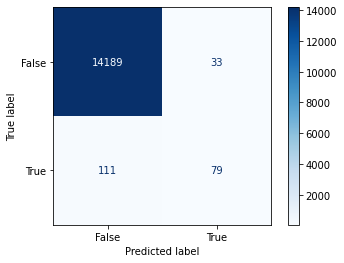

In [33]:
plot_confusion_matrix(log_class, x_train_prep, y_train, cmap='Blues')
plt.show()

Based on the awkward bumpiness of our precision curve, it seems that our model is hanging on to a lot of noise as  the recall goes down. Its not until recall is next to nothing that it spikes quickly.

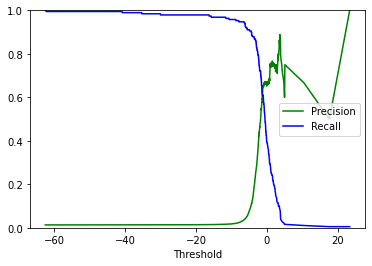

In [34]:
#Find scoring thresholds for estimator
log_dec_scores = cross_val_predict(log_class, x_train_prep, y_train, cv=3, n_jobs=-1, method='decision_function')

#Calculate values needed to plot our curve
log_precisions, log_recalls, log_thresholds = precision_recall_curve(y_train, log_dec_scores)

plot_precision_recall(log_precisions, log_recalls, log_thresholds)
plt.show()

However, in cross-validation accuracy (3-folds), it seems to performing less well then it did so on this instance.  

In [35]:
log_class_f1, log_class_acc, log_class_auc = get_eval_scores(x_train_prep, y_train, log_class_pred, log_class)

Estimator: LogisticRegressionCV(max_iter=1000)
Precision: 0.71
Recall: 0.42
F1: 0.52
Accuracy: 0.99
AUC: 0.71
-----


It seems that my original plan of having a very skeptical intital model to make up for some of the variance in our tree-based models doesn't need to be reconsidered. However, lets apply some regularization parameters to our logistic classifier to see if we can get it to a somewhat better solution. Since I already intialized this classifier with the grid search parameters from an earlier run, this should go fairly quickly.

In [36]:
#Search param space and fit to our training set

# #If pickle models not called:
# log_grid_search.fit(x_train_prep, y_train)

In [37]:
log_grid_pred = log_grid_search.predict(x_train_prep)

Success! The regularization seem to help the model a bit, although it did take a performance hit. However, in the grand scheme of things it's not super important, as I will be stacking this weak learner with my other models for balance later.

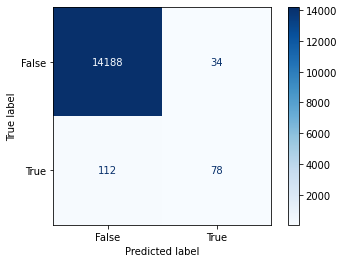

In [38]:
plot_confusion_matrix(log_grid_search, x_train_prep, y_train, cmap='Blues')
plt.show()

Based on the precision/recall graph below, it looks like there is some strange behavior as the threshold increases. My interpretation here is that as we try to minimize our recall and convert all of our false negatives into true positives, due to the scarcity of our labels we end up increasing the denominator of our threshold calculations by a wide margin before we ever find an equal amount of true positives or false positives to balance it out.

Thinking about the goal of our task, I'm partial to the idea that our model should be more sensitive to false negatives than false positives. Given that we are attempting to understand what low-level features help predict successful runs, it seems it more important to identify all possible WR runs, even if there are a few near misses, rather than the inverse. 

That being said, though, with the idea of generalizing this model potentially to other games/categories in the future, I am hesitant to optimize for high precision because of our class imbalance. I don't want any of our models to naively assign far too many or far too few in this early stage, so I will be relying primarily on the F1 Score in tandem with our reported precsions and recalls to evaluate performance. While I don't want both precision and recall to sit in a low optimum (as shown below, about 0.62), I also don't want them to be wildly different.

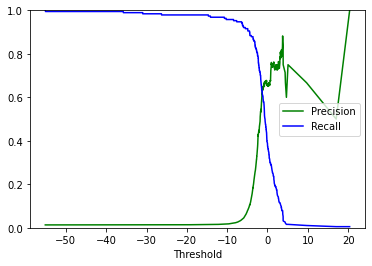

In [39]:
#Find scoring thresholds for estimator
log_grid_dec_scores = cross_val_predict(log_grid_search, x_train_prep, y_train, cv=3, n_jobs=-1, method='decision_function')

#Calculate values needed to plot our curve
log_grid_precisions, log_grid_recalls, log_grid_thresholds = precision_recall_curve(y_train, log_grid_dec_scores)

plot_precision_recall(log_grid_precisions, log_grid_recalls, log_grid_thresholds)
plt.show()

That being said above, our regularized model is perfoming quite weakly at the moment. However, this is fine, as I am hoping to use this weak quality for my purpose.

In [40]:
log_grid_f1, log_grid_acc, log_grid_auc = get_eval_scores(x_train_prep, y_train, log_grid_pred, log_grid_search)

Estimator: LogisticRegressionCV(Cs=50, max_iter=1500, penalty='l1', solver='liblinear')
Precision: 0.7
Recall: 0.41
F1: 0.52
Accuracy: 0.99
AUC: 0.7
-----


Moving on to Gradient Descent. This one I am expecting to overfit on the first pass.

In [41]:
# #If pickle models not called:
# gb_class.fit(x_train_prep, y_train)
gb_class_pred = gb_class.predict(x_train_prep)

In [42]:
gb_dec_scores = cross_val_predict(gb_class, x_train_prep, y_train, cv=3, n_jobs=-1, method='decision_function')

Performance here is good, it hasn't completed fit every part of the model, but there is still some room for improvment.

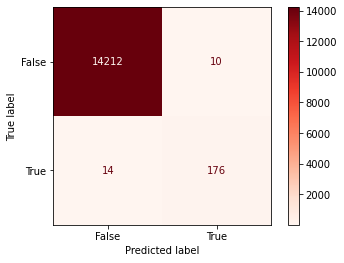

In [43]:
plot_confusion_matrix(gb_class, x_train_prep, y_train, cmap='Reds')
plt.show()

Taking a closer look at the GradientBoost curves though, while recall seems to require a much higher threshold before it reaches a minimum, it actually is converging on a minimum much faster than Logistic Regression. Threshold range for our regualrized logistic model was approx. -50 to 20, whereas here with GradientBoost, we only have a range of -6 to 8.

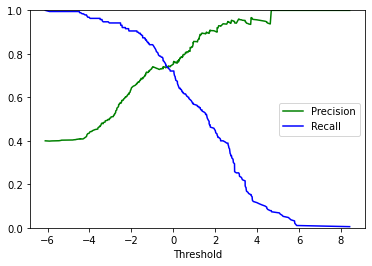

In [44]:
gb_precisions, gb_recalls, gb_thresholds = precision_recall_curve(y_train, gb_dec_scores)

plot_precision_recall(gb_precisions, gb_recalls, gb_thresholds)
plt.show()

In [45]:
gb_class_f1, gb_class_acc, gb_class_auc = get_eval_scores(x_train_prep, y_train, gb_class_pred, gb_class)

Estimator: GradientBoostingClassifier()
Precision: 0.95
Recall: 0.93
F1: 0.94
Accuracy: 1.0
AUC: 0.96
-----


Lets take a peek at our GBClass params to get an ideas of where in the feature space we should explore during our RandomSearch to better regularize this classifier.

In [46]:
gb_class.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

It seems like its really overfitting in the leaf nodes and splits, I'll set the minimums a bit higher so there is is less of a chance of it overfitting in subsequent runs. As a reminder, I initialized it with the parameters below, when I called my models at the beginning of this section.

In [47]:
# gb_params = {'min_samples_split': [20, 40, 80],
#             'min_samples_leaf': [10,20,40],
#             'random_state': [42]}

# gb_rand_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),             
#                                     param_distributions=gb_params,
#                                     n_iter=10,
#                                     cv=2,
#                                     random_state=42,
#                                     n_jobs=-1)

In [48]:
# # #If pickle models not called:
# gb_rand_search.fit(x_train_prep, y_train)

In [49]:
gb_rand_search.best_params_

{'random_state': 42, 'min_samples_split': 20, 'min_samples_leaf': 20}

In [50]:
gb_rand_pred = gb_rand_search.predict(x_train_prep)

In [51]:
gb_rand_dec_scores = cross_val_predict(gb_rand_search, x_train_prep, y_train, cv=3, n_jobs=-1, method='decision_function')

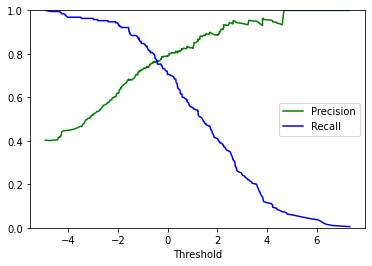

In [52]:
gb_rand_precisions, gb_rand_recalls, gb_rand_thresholds = precision_recall_curve(y_train, gb_rand_dec_scores)

plot_precision_recall(gb_rand_precisions, gb_rand_recalls, gb_rand_thresholds)
plt.show()

It looks like we were able to once again reduce the overfitting a bit, but not to a large extent. If we were only operating with this model, I would go back and add some strong regularization so it could be slightly more robust, but considering that we will stack this one later, and our Random Forest is very likely to grossly overfit our data, I'm happy with this one riding the middle lane.

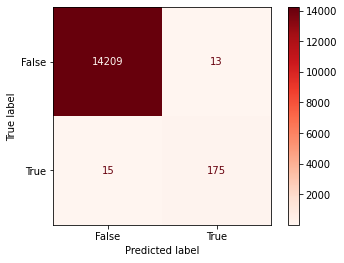

In [53]:
plot_confusion_matrix(gb_rand_search, x_train_prep, y_train, cmap='Reds')
plt.show()

In [54]:
gb_rand_f1, gb_rand_acc, gb_rand_auc = get_eval_scores(x_train_prep, y_train, gb_rand_pred, gb_rand_search)

Estimator: RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'min_samples_leaf': [10, 20, 40],
                                        'min_samples_split': [20, 40, 80],
                                        'random_state': [42]},
                   random_state=42)
Precision: 0.93
Recall: 0.92
F1: 0.93
Accuracy: 1.0
AUC: 0.96
-----


Now on to Random Forest! This will be our final classifier and is the one I am planning to deliberately overfit to compensate for the performance of the other classifiers. With any luck, this should balance the out when we do the stacking later. That being said, I'm not too concerned about the precision/recall tradeoff as I know that they are certainly going to be 1.

In [55]:
# #If pickle models not called:
# rf_class.fit(x_train_prep, y_train)
rf_class_pred = rf_class.predict(x_train_prep)

In [56]:
rf_class_pred = rf_class.predict(x_train_prep)

As predicted! The Random Forest was always going to lean towards overfitting with any sort of regularization or tuning. That being said however, this was a welcome and expected outcome.

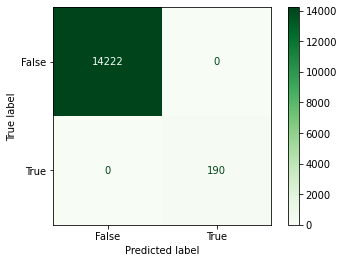

In [57]:
plot_confusion_matrix(rf_class, x_train_prep, y_train, cmap='Greens')
plt.show()

In [58]:
rf_f1, rf_acc, rf_auc = get_eval_scores(x_train_prep, y_train, rf_class_pred, rf_class)

Estimator: RandomForestClassifier()
Precision: 1.0
Recall: 1.0
F1: 1.0
Accuracy: 1.0
AUC: 1.0
-----


Finally lets stack all of our regularized models plus our Random Forest!

In [59]:
# #If pickle models not called
# stacker.fit(x_train_prep, y_train)

In [60]:
stack_pred = stacker.predict(x_train_prep)

All in all the stacked model seems to be performing well, but with some room for improvement. Additionally as discussed earlier, its tending towards higher recall instead of higher precision, which is ideally good for our context. 

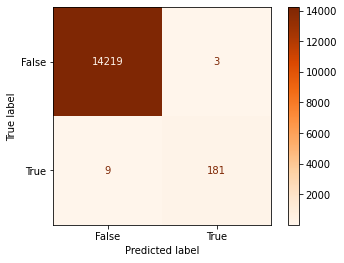

In [61]:
plot_confusion_matrix(stacker, x_train_prep, y_train, cmap='Oranges')
plt.show()

Further inspection of our scoring metrics reveals the performance across our metrics are pretty consistent, mantaining high F1 scores while also not compromisng on overall accuracy. Overall as pretty strong model: but can it generalize to our test data?

In [62]:
stacker_f1, stacker_acc, stacker_auc = get_eval_scores(x_train_prep, y_train, stack_pred, stacker)

Estimator: StackingClassifier(estimators=[('log_class',
                                LogisticRegressionCV(Cs=50, max_iter=1500,
                                                     penalty='l1',
                                                     solver='liblinear')),
                               ('gb_rand',
                                RandomizedSearchCV(cv=2,
                                                   estimator=GradientBoostingClassifier(),
                                                   n_jobs=-1,
                                                   param_distributions={'min_samples_leaf': [10,
                                                                                             20,
                                                                                             40],
                                                                        'min_samples_split': [20,
                                                                                    

Looking at our models on the whole, it seems like we are getting good performance on our training set, however given each model's natural tendency to overfit without regularization, this isn't particularly useful. I am expecting a big performance hit for our out-of-the-box Logistic and Gradient Boost models.

That being said, by stacking the regularized version of these two, plus the out of the box Random Forest, I'm hoping that each of these can learn some different aspects of our feature space, and then make a strong learner out of these weak learners. The performance hits on different aspects of the model would be helpful in this aim.

In [63]:
#Create and call a df with all of our evaluation metrics, based on 
train_model_round_up = pd.DataFrame(data=np.array([[log_class_acc, log_class_auc, log_class_f1],[log_grid_acc, log_grid_auc, log_grid_f1],[gb_class_acc, gb_class_auc, gb_class_f1],[gb_rand_acc, gb_rand_auc, gb_rand_f1],[rf_acc, rf_auc, rf_f1], [stacker_acc, stacker_auc, stacker_f1]]),columns=['Accuracy', 'AUC', 'F1 Score'], index=['Log Reg', 'Log Reg_Grid','GBoost','GBoost_Rand','RandForest','Stacked'])

train_model_round_up

,Accuracy,AUC,F1 Score
Log Reg,0.990008,0.706735,0.523179
Log Reg_Grid,0.989870,0.704068,0.516556
GBoost,0.998335,0.962806,0.936170
GBoost_Rand,0.998057,0.960069,0.925926
RandForest,1.000000,1.000000,1.000000
Stacked,0.999167,0.976210,0.967914


Now let's test our models on our test set!

In [64]:
x_test_prep = pipeline.transform(x_test)

log_class_test_pred = log_class.predict(x_test_prep)
log_grid_test_pred = log_grid_search.predict(x_test_prep)
gb_class_test_pred = gb_class.predict(x_test_prep)
gb_rand_test_pred = gb_rand_search.predict(x_test_prep)
rf_test_pred = rf_class.predict(x_test_prep)
stacker_test_pred = stacker.predict(x_test_prep)

In [65]:
log_class_f1, log_class_acc, log_class_auc = get_eval_scores(x_test_prep, y_test, log_class_test_pred, log_class)
log_grid_f1, log_grid_acc, log_grid_auc = get_eval_scores(x_test_prep, y_test, log_grid_test_pred, log_grid_search)
gb_class_f1, gb_class_acc, gb_class_auc = get_eval_scores(x_test_prep, y_test, gb_class_test_pred, gb_class)
gb_rand_f1, gb_rand_acc, gb_rand_auc = get_eval_scores(x_test_prep, y_test, gb_rand_test_pred, gb_rand_search)
rf_f1, rf_acc, rf_auc = get_eval_scores(x_test_prep, y_test, rf_test_pred, rf_class)
stacker_f1, stacker_acc, stacker_auc = get_eval_scores(x_test_prep, y_test, stacker_test_pred, stacker)

Estimator: LogisticRegressionCV(max_iter=1000)
Precision: 0.74
Recall: 0.43
F1: 0.54
Accuracy: 0.99
AUC: 0.71
-----
Estimator: LogisticRegressionCV(Cs=50, max_iter=1500, penalty='l1', solver='liblinear')
Precision: 0.74
Recall: 0.43
F1: 0.54
Accuracy: 0.99
AUC: 0.71
-----
Estimator: GradientBoostingClassifier()
Precision: 0.83
Recall: 0.72
F1: 0.77
Accuracy: 0.99
AUC: 0.86
-----
Estimator: RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'min_samples_leaf': [10, 20, 40],
                                        'min_samples_split': [20, 40, 80],
                                        'random_state': [42]},
                   random_state=42)
Precision: 0.81
Recall: 0.74
F1: 0.78
Accuracy: 0.99
AUC: 0.87
-----
Estimator: RandomForestClassifier()
Precision: 0.84
Recall: 0.66
F1: 0.74
Accuracy: 0.99
AUC: 0.83
-----
Estimator: StackingClassifier(estimators=[('log_class',
                                LogisticRegressionCV(

So far the results look promising! Let's look at it in a slightly more cleaned up version!

In [66]:
test_model_round_up = pd.DataFrame(data=np.array([[log_class_acc, log_class_auc, log_class_f1],[log_grid_acc, log_grid_auc, log_grid_f1],[gb_class_acc, gb_class_auc, gb_class_f1],[gb_rand_acc, gb_rand_auc, gb_rand_f1],[rf_acc, rf_auc, rf_f1], [stacker_acc, stacker_auc, stacker_f1]]),columns=['Accuracy', 'AUC', 'F1 Score'], index=['Log Reg', 'Log Reg_Grid','GBoost','GBoost_Rand','RandForest','Stacked'])

test_model_round_up

,Accuracy,AUC,F1 Score
Log Reg,0.990566,0.711782,0.540541
Log Reg_Grid,0.990566,0.711782,0.540541
GBoost,0.994451,0.860718,0.772727
GBoost_Rand,0.994451,0.871216,0.777778
RandForest,0.993896,0.828944,0.738095
Stacked,0.995006,0.902990,0.808511


Overall, it looks like our Stacked model had the best peformance on this task. The top F1 Score with a higher AUC on the test set demonstrate that even though the model might miss a few labels in the wild (it only correctly classed 2/3 of true WR runs), it did so with a more consistency in terms of False Positives and False Negatives. 

Also if we take a closer look at our raw output from the cell previous to our model round-up, that the indivdual models with regularization only performed marginally better or the same as their counterparts across all measures. Thus if necessary we could send more time tuning them, but for our purposes this is good enough.

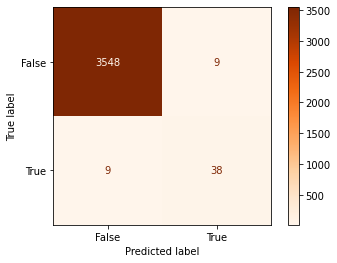

In [67]:
plot_confusion_matrix(stacker, x_test_prep, y_test, cmap='Oranges')
plt.show()

Taking a closer look at our `stacker` estimator, we can see the breakdown of how much of each model contributed to our prediction. Luckily it seems that all three model contributed more or less equally, although it did seem to prefer the Random Forest and not the Logistic Regression.

In [68]:
#Print the zipped tuples for the estimators and the importance values for those estimators
for classifier in zip([i for i,j in stacker.estimators], stacker.final_estimator_.feature_importances_):
    print(classifier)

('log_class', 0.23424793490079715)
('gb_rand', 0.335166121855139)
('rf_class', 0.4305859432440638)


But what was the most important feature in our prediction? Luckily we can use the `feature_importances_` attribute of our Random Forest Classifier to get an idea.

But first we are going to need to figure out in what or our columns are after the got passed into our `ColumnTransformer` method.

In [69]:
pipeline.transformers_

[('num',
  Pipeline(steps=[('std_scaler', StandardScaler())]),
  ['run_time',
   'run_views',
   'min_runtime_y-m',
   'cat_runners_y-m',
   'cat_total_views_y-m',
   'cat_runner_life_runs',
   'runner_wr_count']),
 ('cat',
  Pipeline(steps=[('endcoder', OneHotEncoder(handle_unknown='ignore'))]),
  ['category_id', 'system_id']),
 ('remainder', 'drop', [0, 1, 6, 7])]

Now that we know which columns being to which indices in our `feature_importances_` attribute, we can zip these results with our transformers list for easy comparison.

In [70]:
#Print the zippped tuples for numerics
for feature in zip(
    #List comp. for the names of the columns from transformers
    [i for i in pipeline.transformers_[0][2]], 
    #List comp. for the first 7 features in the RF feature importance array
    [i for i in rf_class.feature_importances_][0:7]
    ):
    print(feature)

('run_time', 0.1230046308740129)
('run_views', 0.09815524621379855)
('min_runtime_y-m', 0.08161931725424625)
('cat_runners_y-m', 0.09671512066687954)
('cat_total_views_y-m', 0.07658322572619818)
('cat_runner_life_runs', 0.09235283035954457)
('runner_wr_count', 0.3666437344826923)


In [71]:
#Print the zipped tuples for categoricals
for feature in zip(
    #List comp. for the names of the columns from transformers
    [i for i in pipeline.transformers_[1][2]],
    #List comprehension to sum the importance for each categorical feature, since each category was assigned its own column, and thus its own importance score. 
    [sum(rf_class.feature_importances_[7:12]), sum(rf_class.feature_importances_[12:])]):
    print(feature)

('category_id', 0.02311317057088624)
('system_id', 0.04181272385174143)


Since we hot encoded our categorical features, `OneHotEncoder` created binary feature columns for each category. So according to our transformer list, the first 5 items in the array should be our categories (we had 5 in total, so one column each). The rest of the items should belong to `system_id` (which is three) since the rest of the columns in our DataFrame were automatically dropped by `ColumnTransformer` since we did not explicitly specify them in our transformation.

Taking the results above together, our most important feature was predicting a run was 'runner_wr_count' along with 'run_time', and then a tie between 'run_views' and 'cat_runners_y-m'.

This tracks with the context of our problem:
 - Runners who were previous WR run holders are likely to set a new record in subsequent runs 
 - Having the lowest 'run_time' is the primary condition for run, thus having a faster would mean a world record is more likely
 - Central to our problem, world record runs, and runs close to beating world records have more views. This bodes well for us, as it validates our inuition that a viable way to grow your view/sub rate as a runnner is to earn a spot on the leaderboard.
 - While it makes a more competitive environment for runners, having more runners attempting runs in a given period of time makes a world record run more likely.

## Conclusion

While we were able to get strong peformance from a variety of classifier models, at the end of the day the combinatory approach also seemed to impart the best results.

 We also learned that we are able to predict whether or not a speedrun is a part of this target class, simply based on some publicly available data and some rudimentary data manipulation, we also were able to takeaway some key features that were helpful in our prediction.
 
Hopefully future projects or machine learning tasks in this area can expound on this work by expanding the data set to a large swath of the speedrunning scene, our using different approaches to address nominally different task (such as time series predictions or regression tasks). 

By contributing the results of this classification approach, I hope I have demonstrated the baseline viability of using ML models to predict this kind of phenomena, and I hope that I can continue to work on the project in the future.

In [178]:
# I used this block to dump my fitted/refitted models to disk when I was finished
pickle.dump(log_class, open('./log_class.sav', 'wb'))
pickle.dump(log_grid_search, open('./log_reg.sav', 'wb'))
pickle.dump(gb_class, open('./gb_class.sav', 'wb'))
pickle.dump(gb_rand_search, open('./gb_rand.sav', 'wb'))
pickle.dump(rf_class, open('./rf_class.sav', 'wb'))
pickle.dump(rf_blend, open('./rf_blend.sav', 'wb'))
pickle.dump(stacker, open('./stacker.sav', 'wb'))
